In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import corner.corner
from emcee.autocorr import integrated_time
from impulse.base import PTTestSampler
from impulse.product_space import ProductSpace
from test_model import make_multiple_sin_data

# test model things:
from test_model import make_sin_data, LnLikelihood, LnPrior

In [4]:
x, data, omega_real, a_real, phi_real = make_multiple_sin_data(1000, 2)

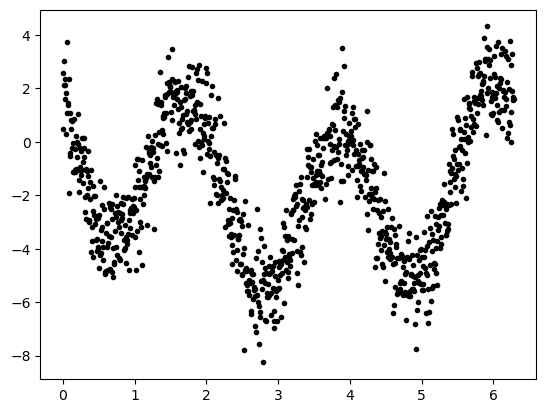

In [5]:
plt.plot(x, data, 'k.')

In [6]:
class LogLikelihood:
    def __init__(self, x, data, sigma=1):
        self.x = x
        self.sigma = sigma
        self.data = data

    def __call__(self, params):
        if len(params) % 3 != 0:
            raise ValueError("Number of parameters must be a factor of 3")
        omega = params[0::3]
        a = params[1::3]
        phi = params[2::3]
        
        func = np.array([a * np.sin(omega * self.x + phi) for omega, a, phi in zip(omega, a, phi)])
        result = np.sum(-0.5 * (np.sum(func, axis=0) - self.data)**2)
        if np.isfinite(result):
            return result
        else:
            return -np.inf

class LogPrior:
    def __init__(self, omega_range=(0, 3), a_range=(0, 5), phi_range=(0, np.pi)):
        self.omega_min = omega_range[0]
        self.omega_max = omega_range[1]
        self.a_min = a_range[0]
        self.a_max = a_range[1]
        self.phi_min = phi_range[0]
        self.phi_max = phi_range[1]

    def __call__(self, params):
        if len(params) % 3 != 0:
            raise ValueError("Number of parameters must be a factor of 3")
        omega = params[0::3]
        a = params[1::3]
        phi = params[2::3]
        if np.any(omega < self.omega_min) or np.any(omega > self.omega_max):
            return -np.inf
        if np.any(a < self.a_min) or np.any(a > self.a_max):
            return -np.inf
        if np.any(phi < self.phi_min) or np.any(phi > self.phi_max):
            return -np.inf
        else:
            return 0

In [13]:
param_names = [['omega1', 'a1', 'phi1'], ['omega1', 'a1', 'phi1', 'omega2', 'a2', 'phi2']]

In [19]:
pspace = ProductSpace(['model1', 'model2'], [LogLikelihood(x, data), LogLikelihood(x, data)], [LogPrior(), LogPrior()], param_names)

In [23]:
# now sample it!
sampler = PTTestSampler(pspace.ndim, pspace.loglikelihood, pspace.logprior, cov_update=100, ntemps=8, swap_steps=10, inf_temp=True)

In [24]:
sampler.sample(np.array([2, 3, 1, 2, 3, 1, 2, 3, 1, 0.3]), 100_000, thin=1)

100%|██████████| 100000/100000 [02:54<00:00, 573.79it/s]


In [25]:
with open('/Users/aaron/Documents/GitHub/impulse_mcmc/examples/chains/chain_0.txt', 'r') as fp:
    chain = np.loadtxt(fp)

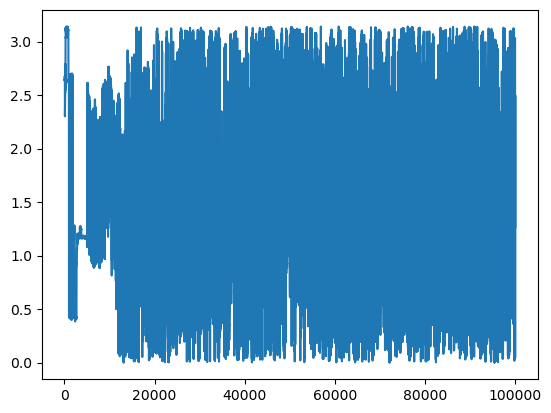

In [31]:
plt.plot(chain[:, 2])

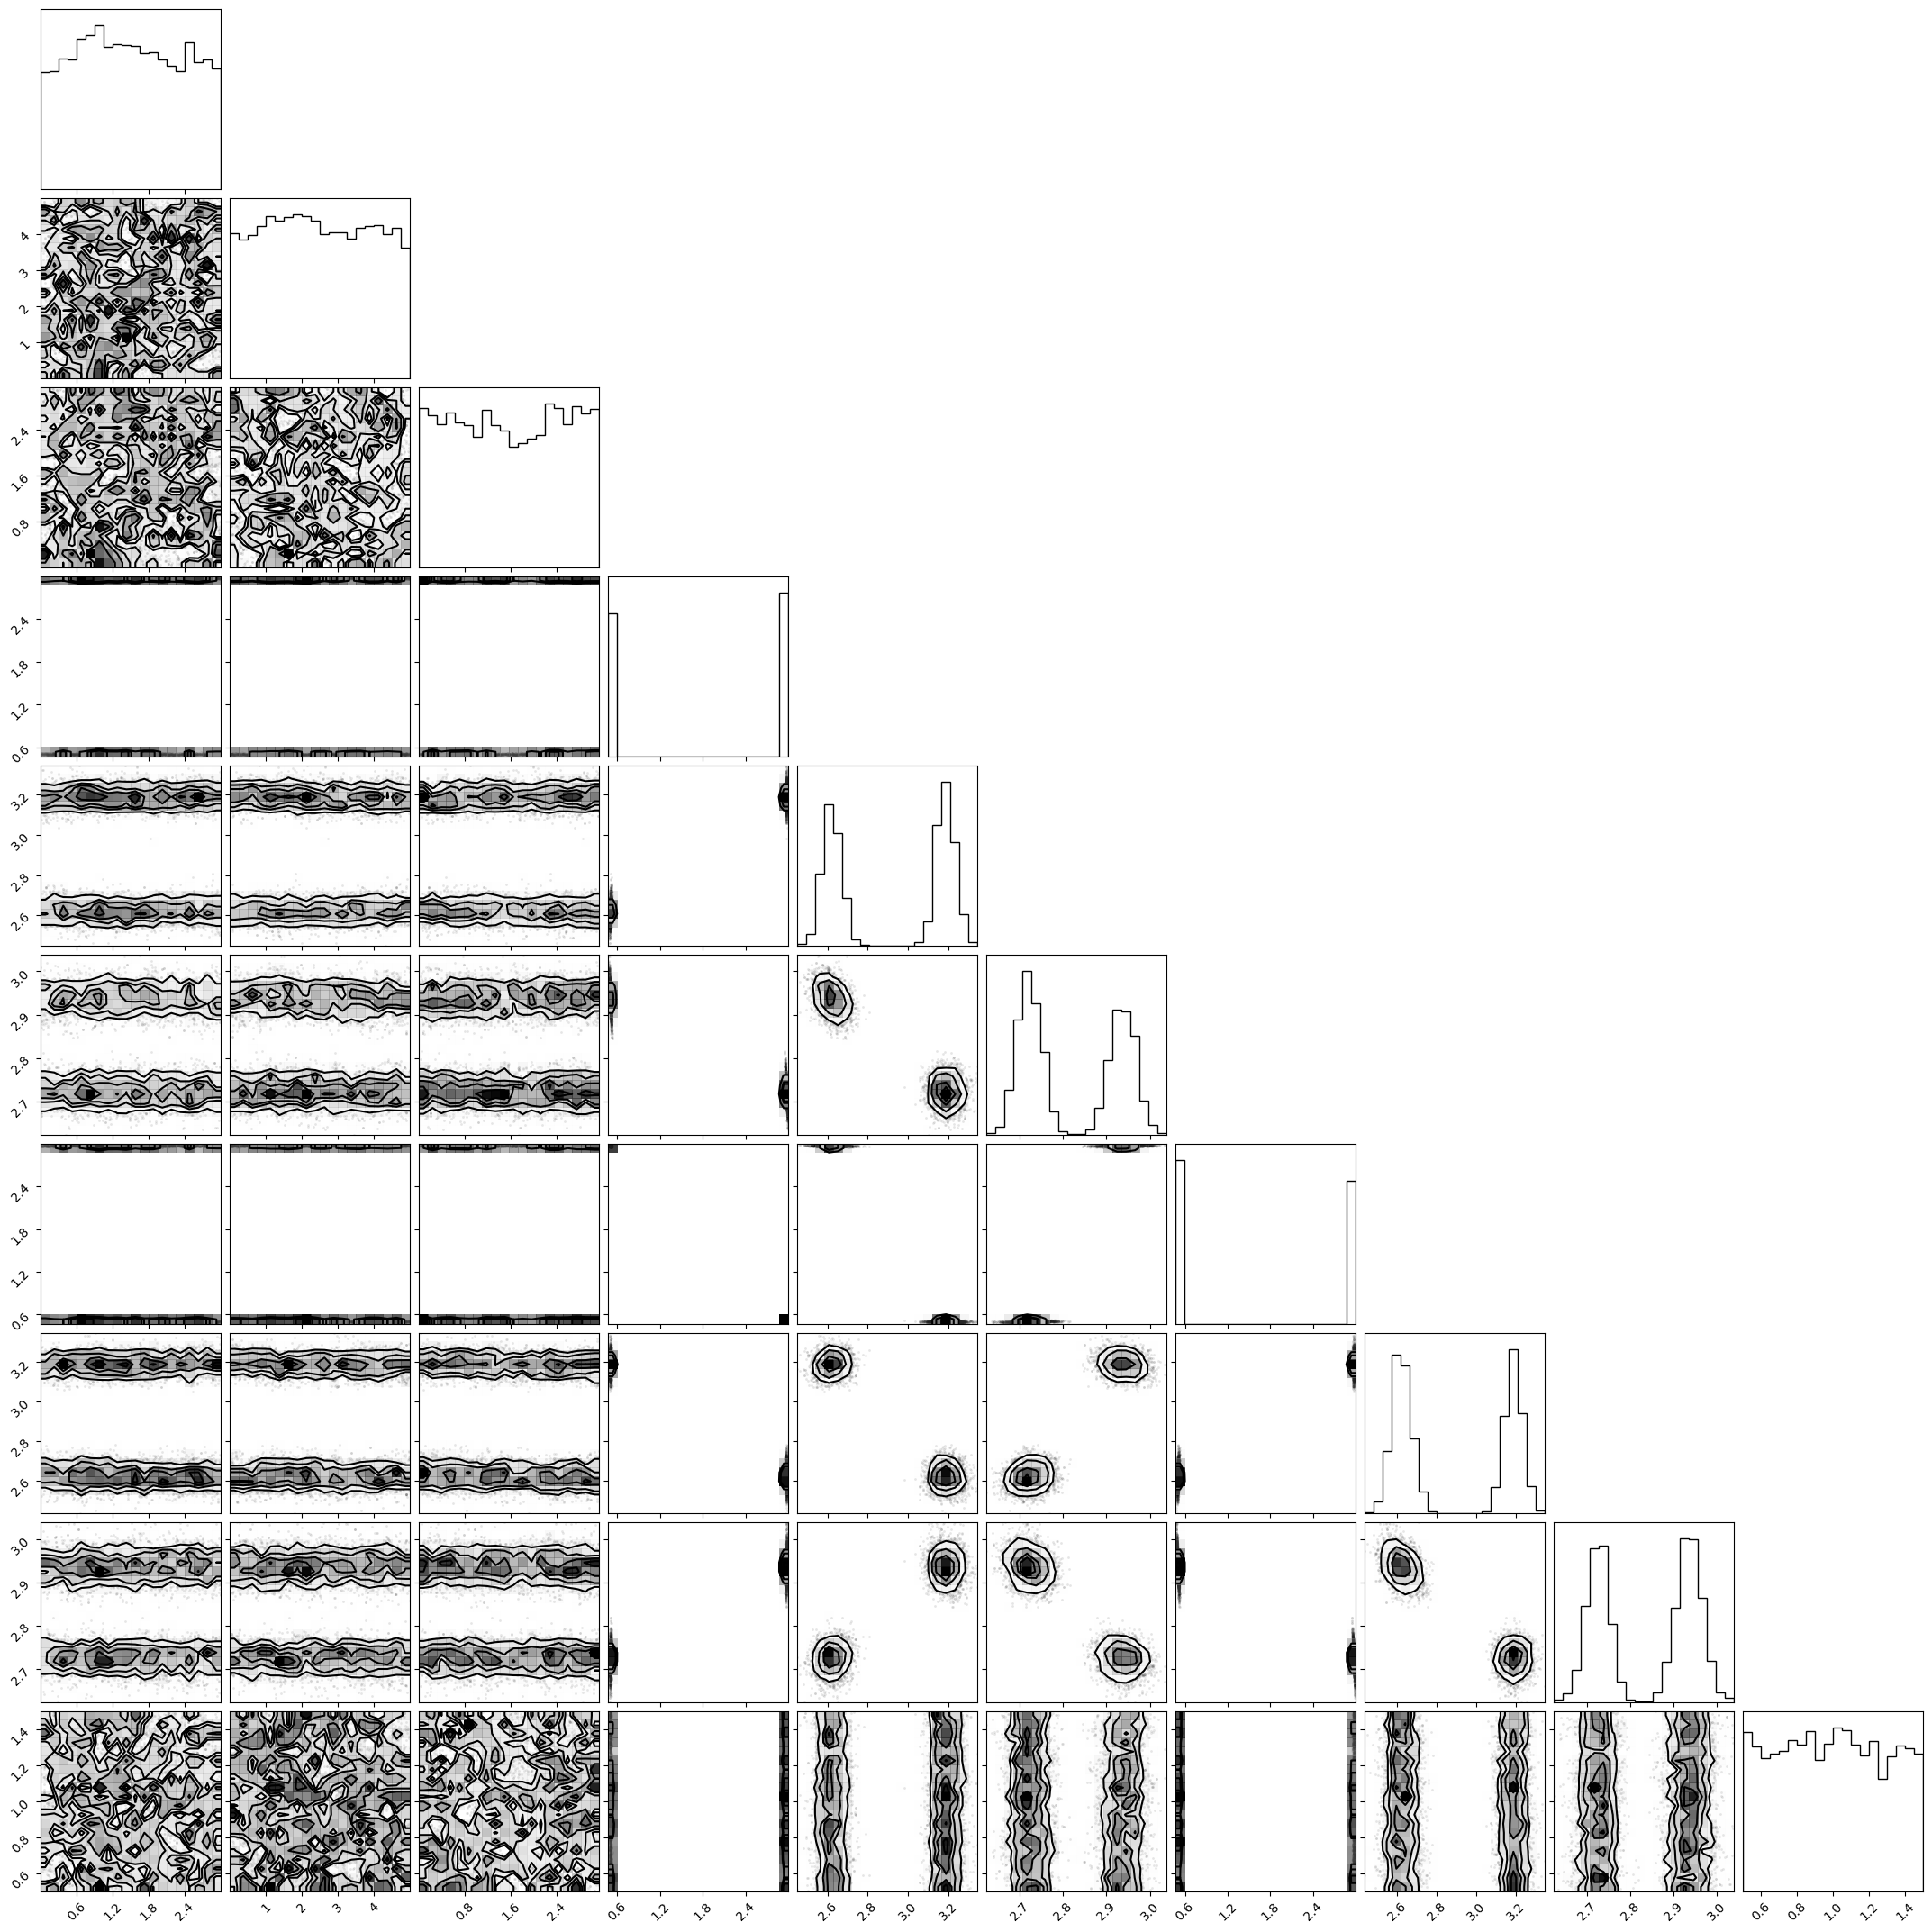

In [59]:
corner.corner(chain[40_000::10, :-4]);

In [41]:
from emcee.autocorr import integrated_time

In [58]:
integrated_time(chain[40_000:, 10])

array([44.71934105])

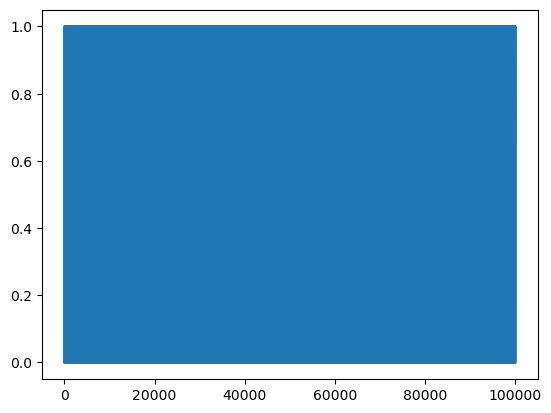

In [33]:
plt.plot(chain[:, 12])